# Effect of Number of Children and Gender on Adult Student's Academic Interests and Performance

## Project Description
<br>The project uses survey data on adult students at Robert Kennedy College (Switzerland) to test
<br>whether the number of children and students' gender affect their academic perfomance.
<br>It also tests gender based hypotheses about students' interest on data-related fields.
<br>
<br>**Techniques used:**
<br>Data Cleaning, Descriptive Statistics, T-Tests, 
<br>Randomization Tests, Chi-Squared Tests, 
<br>Comparison of Frequency Distributions, Matplotlib Data Visualization

## Environment Setup

### Imports

In [1]:
!python3 -m pip install plotly

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats
import seaborn as sns
import openpyxl
import pycountry
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
from plotly import graph_objs as go
init_notebook_mode(connected=True)
%matplotlib inline

## Data Profiling

### Open and View the File

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
file = pd.read_csv(r"data/dataanalytics-class-data.csv")
file.head()

,ID,Start time,Completion time,Email,Gender,Age,Closest biggest city near you,Number of kids (<18y) living with you,Birth Year,Number of modules completed so far,Average mark so far,Prediction for this module's mark,I enjoy working with data,I am excited about working with data,I am afraid of working with data,I am interested in understanding Data Analytics,I plan to work hard in this module,"Height (absolute value, in centimeters (cm) - sorry imperial system users!)",Height (relative)
0,2,12/17/20 9:09:33,12/17/20 9:10:55,anonymous,Woman,40-49,Lagos,0,1975,5,62.0,62,Agree,Agree,Completely Disagree,Agree,Agree,175.0,very tall
1,3,12/17/20 9:09:27,12/17/20 9:11:01,anonymous,Man,30-39,Dhaka,0,1011986,5,57.0,65,Agree,Agree,Completely Disagree,Agree,Agree,172.0,average
2,4,12/17/20 9:09:34,12/17/20 9:14:39,anonymous,Man,30-39,Hanoi,0,1989,5,61.0,64,Agree,Meh,Disagree,Meh,Meh,178.0,average
3,5,12/17/20 9:19:54,12/17/20 9:27:03,anonymous,Woman,50-59,Stockholm,0,1970,5,60.0,100,Agree,Agree,Completely Disagree,Agree,Completely Agree,164.0,average
4,6,12/17/20 9:28:13,12/17/20 9:35:44,anonymous,Man,40-49,Accra,3,1979,5,60.0,70,Completely Agree,Agree,Completely Disagree,Completely Agree,Meh,170.0,average


In [ ]:
file.tail()

In [ ]:
file.columns

#### Dropping columns with data that is not useful to the analysis

In [4]:
unrelated_columns = ['ID','Email']
file = file.drop(columns=unrelated_columns)

#### Renaming all columns to snake case and shorter names 

In [5]:
file = file.rename(columns={"Start time" : "Start_time",
                     "Completion time": "End_time",
                     "Closest biggest city near you": "City",
                     "Number of kids (<18y) living with you": "Kids",
                     "Birth Year": "Birth_year",
                     "Number of modules completed so far": "Modules_num", 
                     "Average mark so far": "Average_grade", 
                     "Prediction for this module's mark": "Prediction_grade",
                     "Height (absolute value, in centimeters (cm) - sorry imperial system users!)" : "Height_cm",
                     "Height (relative)": "Height_relative", 
                     "I enjoy working with data": "Enjoy_data", 
                     "I am excited about working with data": "Excited_data",
                     "I am afraid of working with data": "Afraid_data",
                     "I am interested in understanding Data Analytics": "Interested_DA",
                     "I plan to work hard in this module": "Work_hard",
                    })

In [6]:
file_info = file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Start_time        109 non-null    object 
 1   End_time          109 non-null    object 
 2   Gender            109 non-null    object 
 3   Age               109 non-null    object 
 4   City              109 non-null    object 
 5   Kids              109 non-null    int64  
 6   Birth_year        109 non-null    int64  
 7   Modules_num       109 non-null    object 
 8   Average_grade     106 non-null    float64
 9   Prediction_grade  109 non-null    int64  
 10  Enjoy_data        109 non-null    object 
 11  Excited_data      109 non-null    object 
 12  Afraid_data       109 non-null    object 
 13  Interested_DA     109 non-null    object 
 14  Work_hard         109 non-null    object 
 15  Height_cm         109 non-null    float64
 16  Height_relative   109 non-null    object 
dt

#### Grouping columns by quantitative and qualitative

In [ ]:
quantitative_cols = ["Start_time", "End_time", "Age", "Kids", "Modules_num", "Average_grade", "Prediction_grade", "Height_cm", 
                     "Height_relative", "Enjoy_data", "Excited_data", "Afraid_data", "Interested_DA", 
                     "Work_hard"]

qualitative_cols = ["Gender", "City"]

#### Grouping columns by scales of measurement: nominal, ordinal, interval, and ratio

In [ ]:
nominal_cols = ["Gender", "City"]
ordinal_cols = ["Height_relative", "Enjoy_data", "Excited_data", "Afraid_data", "Interested_DA", "Work_hard"]
ratio_cols = ["Height_cm", "Age", "Kids", "Modules_num"]
interval_cols = ["Start_time", "End_time", "Average_grade", "Prediction_grade"]

#### Grouping into discrete and continuous 

In [ ]:
discrete = ["Kids", "Modules_num"]
continuous = ["Height_cm", "Age", "Start_time", "End_time", "Average_grade", "Prediction_grade"]

### Data Quality Assessment

In [ ]:
file.dtypes

In [7]:
file.isnull().sum()

Start_time          0
End_time            0
Gender              0
Age                 0
City                0
Kids                0
Birth_year          0
Modules_num         0
Average_grade       3
Prediction_grade    0
Enjoy_data          0
Excited_data        0
Afraid_data         0
Interested_DA       0
Work_hard           0
Height_cm           0
Height_relative     0
dtype: int64

In [ ]:
file.info()
file.head(4)

## Data Cleansing

### Helper Methods

In [8]:
def clean_birth_year(year_value):
    now = datetime.datetime.now()
    current_year = now.year
    digits_num = int(math.log10(year_value))+1
    year_value = str(year_value)
    if (digits_num > 4):
        year_value = year_value[-4:]
    elif (digits_num < 4):
        year_value = current_year - int(year_value)
    return int(year_value)

def convert_age_to_list_range(age_item):
    if "-" in age_item:
        age_item = age_item.split("-")
        first_num = int(age_item[0])
        second_num = int(age_item[1])
        age_item = [first_num, second_num]
    else:
        age_item = age_item.split("+")
        first_num = int(age_item[0])
        second_num = 100
        age_item = [first_num, second_num]
    return age_item

def correct_cities(city):
    city = city.title()
    city = city.strip()
    return city

### Missing Values

The "Average  mark so far" contains less non-null values than other columns. Checking the NaN values.

In [ ]:
file['Average mark so far']

#### Dropping all the rows with null values

In [9]:
file = file.dropna()
file = file.reset_index(drop=True)
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Start_time        106 non-null    object 
 1   End_time          106 non-null    object 
 2   Gender            106 non-null    object 
 3   Age               106 non-null    object 
 4   City              106 non-null    object 
 5   Kids              106 non-null    int64  
 6   Birth_year        106 non-null    int64  
 7   Modules_num       106 non-null    object 
 8   Average_grade     106 non-null    float64
 9   Prediction_grade  106 non-null    int64  
 10  Enjoy_data        106 non-null    object 
 11  Excited_data      106 non-null    object 
 12  Afraid_data       106 non-null    object 
 13  Interested_DA     106 non-null    object 
 14  Work_hard         106 non-null    object 
 15  Height_cm         106 non-null    float64
 16  Height_relative   106 non-null    object 
dt

#### Exploring the Birth Year and Age

In [ ]:
file[['Birth_year', 'Age']]

Using a helper method clean_birth_year() to clean the years: from a more than 4-digit number takes only last 4 digits, for each 2 digit number subtracts the number from the current year to find the birth year 

In [10]:
file["Birth_year"] = file["Birth_year"].apply(clean_birth_year)

Subtracting from the current year the birth year (to explore if it is in the age range)

In [11]:
ages_calculated_by_birth_year = []
now = datetime.datetime.now()
current_year = now.year
for i in file['Birth_year']:
    age = current_year - i
    ages_calculated_by_birth_year.append(age)

file["Age_by_birth_year"] = ages_calculated_by_birth_year

Converting Age string into a list of 2 values

In [12]:
file["Age"] = file["Age"].apply(convert_age_to_list_range)

Comparing "Age" and "Age_by_birth_year" column values

In [ ]:
file[["Age_by_birth_year", "Age"]]

In [13]:
for i in range(0, 106):
    if (file["Age_by_birth_year"].iloc[i] > file["Age"].iloc[i][1]) \
        or (file["Age_by_birth_year"].iloc[i] < file["Age"].iloc[i][0]):
        print("ISSUE")
        print("Age by birth year = ", file["Age_by_birth_year"].iloc[i])
        print("Age Range: ", file["Age"].iloc[i][0], " - ", file["Age"].iloc[i][1])
        
""" The issue results were observed and no significant issues were found, 
    the difference might be in months, or some
    people have put themsleves in 1 year younger group"""
    

ISSUE
Age by birth year =  50
Age Range:  40  -  49
ISSUE
Age by birth year =  50
Age Range:  40  -  49
ISSUE
Age by birth year =  50
Age Range:  40  -  49
ISSUE
Age by birth year =  40
Age Range:  30  -  39
ISSUE
Age by birth year =  62
Age Range:  50  -  59
ISSUE
Age by birth year =  30
Age Range:  20  -  29
ISSUE
Age by birth year =  60
Age Range:  50  -  59
ISSUE
Age by birth year =  30
Age Range:  20  -  29
ISSUE
Age by birth year =  30
Age Range:  20  -  29
ISSUE
Age by birth year =  60
Age Range:  50  -  59
ISSUE
Age by birth year =  50
Age Range:  40  -  49


' The issue results were observed and no significant issues were found, \n    the difference might be in months, or some\n    people have put themsleves in 1 year younger group'

The data exploration above proves that the Age range and Age data can be trusted now


### Errors

In [14]:
file["City"] = file["City"].apply(correct_cities)

### Outliers

##### Displaying the age and grades to find outliers

Text(0.5, 1.0, 'Student Age and Average Grade')

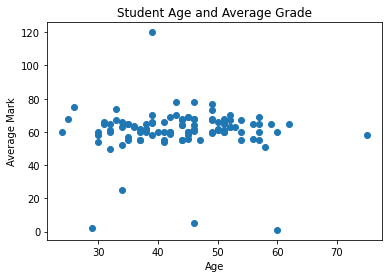

In [15]:
fig, ax = plt.subplots()
ax.scatter(file["Age_by_birth_year"], file["Average_grade"]) 
ax.set_xlabel('Age')
ax.set_ylabel('Average Mark')  
ax.set_title("Student Age and Average Grade")

Conclusions: the grade of 120 is likely to be en error, because the max grade is 100. The grades below 50 shall be examined closer. The grades below 20 should be invetigated since this is a strong failing grade. 

In [16]:
# DROP OUTLIERS
outlier_indexes = []
## study filter() method

for i in range(len(file)):
    if (file["Average_grade"][i] >100) or (file["Average_grade"][i] <=5):
        print(i, " ", file["Average_grade"][i])
        outlier_indexes.append(i)

file = file.drop(outlier_indexes)
file = file.reset_index(drop=True)

56   2.0
79   120.0
88   1.0
95   5.0


Text(0.5, 1.0, 'Student Age and Average Grade')

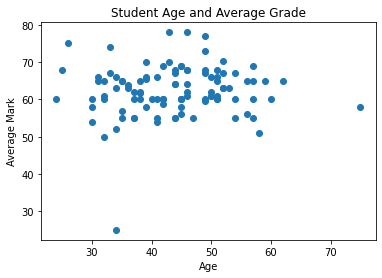

In [17]:
# drawing the plot again with no outliers
fig, ax = plt.subplots()
ax.scatter(file["Age_by_birth_year"], file["Average_grade"]) 
ax.set_xlabel('Age')
ax.set_ylabel('Average Mark')  
ax.set_title("Student Age and Average Grade")

##### Displaying the average grades and the number of completed modules

In [ ]:
fig, ax = plt.subplots()
# sort number if modules from 1-5
ax.scatter(file["Modules_num"], file["Average_grade"]) 
ax.set_xlabel('Number of modules')
ax.set_ylabel('Average Grade') 
ax.set_title("Number of Modules and Average Grade")

##### Displaying the average grades and the number of kids

In [ ]:
fig, ax = plt.subplots()
ax.scatter(file["Kids"], file["Average_grade"]) 
ax.set_xlabel('Number of Kids')
ax.set_ylabel('Average Mark')  
ax.set_title("Number of Kids of a Student and Average Grade")

### Statistical Summaries

In [ ]:
file.describe()

In [ ]:
file["Enjoy_data"].describe()

In [ ]:
file["Excited_data"].describe()

In [ ]:
file["Afraid_data"].describe()

In [ ]:
file["Interested_DA"].describe()

In [ ]:
file["Work_hard"].describe()

In [ ]:
file["Gender"].describe()

In [ ]:
file["Modules_num"].describe()

In [ ]:
file["Height_relative"].describe()

#### Displaying the head

In [62]:
display_file = file[["Gender","Age_by_birth_year", "Kids", "Average_grade", "Excited_data","Enjoy_data"]].tail()
display_file.columns = ["Gender", "Age", "Number of Kids", "Average Grade", "Excited about Data", 
                        "Enjoy Working with Data"]
display_file.columns.tolist()

['Gender',
 'Age',
 'Number of Kids',
 'Average Grade',
 'Excited about Data',
 'Enjoy Working with Data']

In [63]:
color1 = 'white'
color2 = 'lightgrey'
header_color = "lightblue"
values = display_file.iloc[:,0], display_file.iloc[:,1], display_file.iloc[:,2], display_file.iloc[:,3], display_file.iloc[:,4], display_file.iloc[:,5]
fig = go.Figure(data=[go.Table( 
    header=dict(values=display_file.columns.tolist(), 
                fill_color=header_color,
                height = 50,
                align="left",
                font=dict(family="Lato", size=20)), 
    cells=dict(values=values,
               align="left", 
               height = 50, 
               font=dict(family="Lato", size=20), 
               format=None, formatsrc=None,
               fill_color = None
              ))]) 
fig.update_layout(width=1100, height=1000, title="Data Preview")
fig.update_layout({"margin": {"t":50}})
fig.show()

#### Pivot Tables
##### Average Grade Stats by Gender

In [18]:
grouped_by_gender = file.groupby("Gender")
values = grouped_by_gender[["Average_grade"]]
gender_stats = values.agg([np.min, np.max, np.mean, np.std, np.median])
gender_stats.columns = ["Min", "Max", "Mean", "Standard Deviation", "Median"]
gender_stats.iloc[0] = [round(x, 1)for x in gender_stats.iloc[0]]
gender_stats.iloc[1] = [round(x, 1)for x in gender_stats.iloc[1]]

In [19]:
color1 = 'white'
color2 = 'lightgrey'
header_color = "lightblue"
values = gender_stats.columns, gender_stats.iloc[0], gender_stats.iloc[1]
fig = go.Figure(data=[go.Table( 
    header=dict(values=["","Males", "Females"], 
                fill_color=header_color,
                height = 50,
                align="left",
                font=dict(family="Lato", size=18)), 
    cells=dict(values=values,
               align="left", 
               height = 50, 
               font=dict(family="Lato", size=20), 
               format=None, formatsrc=None,
               fill_color = None
              ))]) 
fig.update_layout(width=610, title="Average Grade Statistical Summaries")
fig.update_layout({"margin": {"t":50}})
fig.show()

##### Effect of Number of Kids on Average Grade

In [ ]:
# create a method that groups by and counts agg stats
grouped_by_kids = file.groupby("Kids")
values = grouped_by_kids[["Average_grade"]]
kids_stats = values.agg([np.min, np.max, np.mean, np.std, np.median])
kids_stats
# try without dropping min values for grades 
#draw box plots

In [ ]:
grouped_by_excited = file.groupby("Excited_data")
values = grouped_by_excited[["Average_grade"]]
excited_stats = values.agg([np.min, np.max, np.mean, np.std])
excited_stats

In [ ]:
grouped_by_interested = file.groupby("Interested_DA")
values = grouped_by_interested[["Average_grade"]]
interested_stats = values.agg([np.min, np.max, np.mean, np.std])
interested_stats

#### Average vs Prediction Grade

In [ ]:
## check if the labels are correct
fig, ax = plt.subplots()
ax.scatter(file["Average_grade"], file["Prediction_grade"]) 
ax.set_xlabel('Average Grade')
ax.set_ylabel('Prediction Grade') 
ax.set_title("Average vs Prediction Grade")

#### Frequency Distributions

In [ ]:
sns.kdeplot(file["Age_by_birth_year"], shade=True).set(
    title="Distribution of Student Age Ranges at RKC")
plt.xlabel("Age")
sns.despine(left=True, bottom=True)
plt.show()

In [ ]:
file["Gender"].value_counts().plot.pie(rot=0, 
                                       title="Distribution of Students by Gender at RKC", 
                                       autopct = '%.1f%%')
plt.ylabel('')

In [64]:
gender_counts = file["Gender"].value_counts()

In [65]:
gender_counts = file["Gender"].value_counts()

fig = go.Figure()
fig.add_trace(go.Indicator(
    value = gender_counts[0],
    title = "Males",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 0}))
fig.add_trace(go.Indicator(
    value = gender_counts[1],
    title="Females",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 1}))
fig.update_layout(
    grid = {'rows': 1, 'columns': 2, 'pattern': "independent"},
    template = {'data' : {'indicator': [{
        'delta' : {'reference': 90}}]}})

Separating the grades according to grading scales and creating freq distr for grades

Grades are difficult to visualize just by their unique value counts, therefore, the grades are grouped into ranges and then the frequency of grades in each range is calculated. The table of frequencies of ranges is visualized

In [ ]:
intervals = pd.interval_range(start = 0, end = 100, freq = 10)
grade_freq = pd.Series([0,0,0,0,0,0,0,0,0,0], index = intervals)

for value in file["Average_grade"]:
    for i in intervals:
        if value in i:
            grade_freq.loc[i] +=1
            break
            
grade_freq 


In [ ]:
grade_freq_df = pd.DataFrame([grade_freq.values], columns=["0-10", "11-20", "21-30", 
                                                       "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"])
grade_freq_df

In [ ]:
grade_freq_df.plot.barh(title="Bar Chart of Frequency of Grade Ranges of Students at RKC")
plt.legend(loc='center', bbox_to_anchor=(1.19, 0.7))
# Improve graph

Another was of visualizing the grade ranges could be a Histogram, 
it is quicker to create, since it does not need a frequency table,
and the ranges can be assigned automatically by using "bins"

In [ ]:
file["Average_grade"].plot.hist(bins=10, title = "Histogram of Frequency of Grade Ranges of Students at RKC")

#### Frequency Distribution of Ages

In [ ]:
intervals = pd.interval_range(start = 25, end = 100, freq = 10)
age_freq = pd.Series([0,0,0,0,0,0,0], index = intervals)

for value in file["Age_by_birth_year"]:
    for i in intervals:
        if value in i:
            age_freq.loc[i] +=1
            break
            
age_freq 

In [ ]:
## ( indicates non inclusive value, ] indicates inclusive, therefore, the names of the range start from 36, 46 and etc
age_freq_df = pd.DataFrame([age_freq.values], columns=["25-35", "36-45", "46-55", 
                                                       "56-65", "66-75", "76-85", "86-95"])
age_freq_df

In [ ]:
age_freq_df.plot.barh(title="Frequency of Age Ranges of Students at RKC")

The Histogram Visualization of Age Ranges:

In [ ]:
file["Age_by_birth_year"].plot.hist(range=(25,100),bins=10, title = 
                                    "Histogram of Frequency of Age Ranges of Students at RKC")

This can be considered as a Normal Distribution. 

#### Frequency Distrbibution of Heights

In [ ]:
intervals = pd.interval_range(start = 120, end = 210, freq = 10)
height_freq = pd.Series([0,0,0,0,0,0,0,0,0], index = intervals)

for value in file["Height_cm"]:
    for i in intervals:
        if value in i:
            height_freq.loc[i] +=1
            break
            
height_freq

In [ ]:
height_freq_df = pd.DataFrame([height_freq.values], columns=["120-130", "131-140",
                                                       "141-150", "151-160", "161-170", "171-180", 
                                                       "181-190", "191-200", "201-210"])
height_freq_df

In [ ]:
height_freq_df.plot.barh(title = "Frequency of Height Ranges of Students at RKC")
plt.legend(loc='center', bbox_to_anchor=(1.19, 0.7))


Histogram visualization of height ranges:

In [ ]:
file["Height_cm"].plot.hist(range=(100,210),bins=20, title = 
                                    "Histogram of Frequency of Height Ranges of Students at RKC")

This can be considered as a Uniform Distribution.

#### Frequency Distrbibution by Gender to understand the Diversity of Students at RKC
No ranges were created for this column because it contains only 2 nominal variables and 
it is easy to understand by simple count of unique values per each nominal variable 

#### Frequency Distrbibution by Number of Kids of Students at RKC
No ranges were created for this column because it contains only few variables and 
it is easy to understand by simple count of unique values variable 

In [ ]:
file["Kids"].value_counts().plot.bar(rot=0, title="Distribution of Students by Amount of Kids at RKC")

Histogram view:

In [ ]:
file["Kids"].plot.hist(range=(0,5),bins=6, title = 
                                    "Histogram of Distribution of Students by Amount of Kids at RKC")

This can be considered as a Positive Distribution (Right Skewed)

#### Exploring the columns "Enjoy_data", "Excited_data", "Afraid_data", "Interested_DA" to visualize the interest of students in Data Analytics

In [ ]:
file["Enjoy_data"].value_counts()

In [ ]:
enj_d_list = list(file["Enjoy_data"].value_counts())

In [ ]:
# creating a df for storing the frequencies
enjoy_data_freq_df = pd.DataFrame([enj_d_list], columns=["Agree", "Completely Agree", "Meh", "Disagree"])
enjoy_data_freq_df

In [ ]:
enjoy_data_freq_df.plot.bar(title = "Distribution of Students who Enjoy Data")

#file["Enjoy_data"].value_counts().plot.bar() #this graph was created to compare which one is nicer

In [ ]:
file["Excited_data"].value_counts()

In [ ]:
exc_d_list = list(file["Excited_data"].value_counts())
exc_data_freq_df = pd.DataFrame([exc_d_list], columns=["Agree", "Completely Agree", "Meh", 
                                                       "Disagree", "Completely Disagree"])
exc_data_freq_df

In [ ]:
exc_data_freq_df.plot.bar(title = "Distribution of Students who is Excited about Data")

In [ ]:
file["Interested_DA"].value_counts()

In [ ]:
inter_d_list = list(file["Interested_DA"].value_counts())
inter_data_freq_df = pd.DataFrame([inter_d_list], columns=["Completely Agree", "Agree", "Meh", 
                                                       "Disagree"])
inter_data_freq_df

In [ ]:
inter_data_freq_df.plot.bar(title = "Distribution of Students who is Interested in Data Analytics")

In [ ]:
file["Afraid_data"].value_counts()

In [ ]:
afraid_d_list = list(file["Afraid_data"].value_counts())
afraid_data_freq_df = pd.DataFrame([afraid_d_list], columns=["Completely Disagree", "Disagree", "Meh", "Agree", 
                                                       "Completely Agree"])
afraid_data_freq_df

In [ ]:
afraid_data_freq_df.plot.bar(title = "Distribution of Students who is Afraid of Working with Data")

Conclusions: the majority of students at RKC enjoy and like working with data and are interested to learn about Data Analytics. 
    The majority of students are not afraid of data.

In [ ]:
### IDEA: Gender Analysis (stats, graphs, chi test)

### IDEA: AGE ANalysis (Hypothesis: the older the person, the more he dislikes Data, and the rgades are worse)

### IDEA: KIDS Analysis (Hypothesis: )

## Hypothesis Testing

### Permutation Tests

- **Null Hypothesis: Elder females with kids and younger males with no kids perform equally good at academia**
- **Hypothesis: Elder females with kids perform academically better than younger males with no kids**

1. we aggregate the data and find the mean per each group
2. calculate the mean difference

In [39]:
elder_female_with_kids = file[(file["Age_by_birth_year"]>40) & (file["Kids"]>0) & (file["Gender"]=="Woman")]
elder_female_with_kids_average_grade = elder_female_with_kids["Average_grade"].mean()

younger_male_no_kids = file[(file["Kids"]==0) & (file["Age_by_birth_year"] <= 40)& (file["Gender"]=="Man")]
younger_male_no_kids_average_grade = younger_male_no_kids["Average_grade"].mean()

mean_difference = elder_female_with_kids_average_grade - younger_male_no_kids_average_grade
mean_difference

3.8237104072398154

3. we get the list of all grade values
4. randomly assign these values either to male or to female group
5. conduct the random assignment repeteadly 1000 times (simulating a new study)
6. calculate the mean differences on each iteration and append to a separate list
6. create a dictionary of frequencies of each possible mean difference value

In [54]:
iter_mean_differences = []
group_a_values = elder_female_with_kids["Average_grade"].tolist()
group_b_values = younger_male_no_kids["Average_grade"].tolist()
all_grades = group_a_values + group_b_values

for i in range(1000):
    males = []
    females = []
    for grade in all_grades:
        random_value = np.random.rand()
        if(random_value >= 0.5):
            males.append(grade)
        else:
            females.append(grade)
    iteration_mean_difference = np.mean(females) - np.mean(males)
    iter_mean_differences.append(iteration_mean_difference)

sampling_distribution = {}

for iter_mean_difference in iter_mean_differences:
    if(sampling_distribution.get(iter_mean_difference, False)):
        val = sampling_distribution.get(iter_mean_difference)
        val = val+1
        sampling_distribution[iter_mean_difference] = val
    else:
        sampling_distribution[iter_mean_difference] = 1

8. determine if the mean difference was random or not
- we set a p value threshold of 0.05 (5%)
- we find the frequency of a mean diffirence equal or higher than the mean dif observed in our dataset
- we divide the amount of such mean diffirences by the number of simulated random datasets

In [55]:
frequencies = []
for key in sampling_distribution.keys():
    if key >= mean_difference:
        frequencies.append(key)
frequencies
sum_freq = len(frequencies)
p_value = sum_freq/1000
p_value

0.105

In [59]:
fig = go.Figure()
fig.add_trace(go.Indicator(
    value = p_value*100,
    number = {"suffix":"%"},
    title = "Calculated P-Value",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 0}))
fig.add_trace(go.Indicator(
    number = {"suffix":"%"},
    value = 0.05*100,
    title = "Threshold",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 1}))
fig.update_layout(
    grid = {'rows': 1, 'columns': 2, 'pattern': "independent"},
    template = {'data' : {'indicator': [{
        'delta' : {'reference': 90}}]
                         }})

#### **Conclusion:**
**The p value is 0.117, which is higher than the threshold of 0.05, therefore, we cocnlude that the difference in the means of grades of females and males is purely random.**

### Student T Tests


In [23]:
## testing the same null and alternative hypotheses
elder_female_with_kids = file[(file["Age_by_birth_year"]>40) & (file["Kids"]>0) & (file["Gender"]=="Woman")]
elder_female_with_kids_average_grade = elder_female_with_kids["Average_grade"].mean()

younger_male_no_kids = file[(file["Kids"]==0) & (file["Age_by_birth_year"] <= 40)& (file["Gender"]=="Man")]
younger_male_no_kids_average_grade = younger_male_no_kids["Average_grade"].mean()

mean_difference = elder_female_with_kids_average_grade - younger_male_no_kids_average_grade
print("Elder women with kids: ",elder_female_with_kids_average_grade, 
      "\nYounger men no kids: ", younger_male_no_kids_average_grade,
     "\nDifference: ", mean_difference)

Elder women with kids:  63.59294117647058 
Younger men no kids:  59.76923076923077 
Difference:  3.8237104072398154


In [24]:
color1 = 'white'
color2 = 'lightgrey'
header_color = "lightblue"
values = [round(elder_female_with_kids_average_grade, 1), round(younger_male_no_kids_average_grade, 1)]
fig = go.Figure(data=[go.Table( 
    header=dict(values=["Elder Female with Kids", "Younger Male with No Kids"], 
                fill_color=header_color,
                height = 50,
                align="left",
                font=dict(family="Lato", size=18)), 
    cells=dict(values=values,
               align="left", 
               height = 50, 
               font=dict(family="Lato", size=20), 
               format=None, formatsrc=None,
               fill_color = None
              ))]) 
fig.update_layout(width=610, title = "Average Grade")
fig.update_layout({"margin": {"t":50}})
fig.show()

In [60]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    value = round(elder_female_with_kids_average_grade, 1),
    title = "Average Grade of Elder Females with Kids",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 0}))
fig.add_trace(go.Indicator(
    value = round(younger_male_no_kids_average_grade, 1),
    title="Average Grade of Younger Males with No Kids",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 1, 'column': 0}))

fig.update_layout(
    grid = {'rows': 2, 'columns': 1, 'pattern': "independent"},
    template = {'data' : {'indicator': [{
        'delta' : {'reference': 90}}]
                         }})

#### 1. finding the signal - difference between the mean

In [25]:
signal = mean_difference
signal

3.8237104072398154

#### 2. finding the group variability

In [66]:
variance_group_a = elder_female_with_kids["Average_grade"].var()
variance_group_b = younger_male_no_kids["Average_grade"].var()

print("Variance of Group A (elder females with kids): ", variance_group_a)
print("Variance of Group B (younger males with no kids): ", variance_group_b)

Variance of Group A (elder females with kids):  21.830909558823528
Variance of Group B (younger males with no kids):  133.85897435897434


In [67]:
num_group_a = elder_female_with_kids["Average_grade"].count()
num_group_b = younger_male_no_kids["Average_grade"].count()

print("Number of samples in Group A (elder females with kids): ", num_group_a)
print("Number of samples in Group B (younger males with no kids): ", num_group_b)

Number of samples in Group A (elder females with kids):  17
Number of samples in Group B (younger males with no kids):  13


#### 3. finding the t-value

In [68]:
t_value = signal / math.sqrt((variance_group_a/num_group_a) + (variance_group_b/num_group_b))
print("T-value is ", t_value)

T-value is  1.123599855845671


#### 4. finding the degree of freedom

In [69]:
degree_free = num_group_a + num_group_b - 2
degree_free

28

#### 5. finding the critical value

In [70]:
critical_value = scipy.stats.t.ppf(q=1-.05/2,df=28)
critical_value

2.048407141795244

#### 6. comparing the t-value and the critical value

In [71]:
result = max(t_value, critical_value)
result

2.048407141795244

In [72]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    value = t_value,
    title = "T-Value",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 0}))
fig.add_trace(go.Indicator(
    value = critical_value,
    title="Critical Value",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 1}))

fig.update_layout(
    grid = {'rows': 1, 'columns': 2, 'pattern': "independent"},
    template = {'data' : {'indicator': [{
        'delta' : {'reference': 90}}]
                         }})

#### **Conclusion:**
**The t-value is less than the critical value, therefore, the null hypothesis can not be rejected.**

### Comparing Interest in Data
- **Null Hypothesis: Men and females equally enjoy working with data**
- **Hypothesis: Men enjoy working with data more than females**

In [73]:
males = (file["Gender"]== "Man").sum()
females = (file["Gender"]== "Woman").sum()

males_enj_data = ((file["Gender"]== "Man") & ((file["Enjoy_data"] == "Agree") | 
                                             (file["Enjoy_data"] == "Completely Agree"))).sum()
females_enj_data = ((file["Gender"]== "Woman") & ((file["Enjoy_data"] == "Agree") | 
                                                 (file["Enjoy_data"] == "Completely Agree"))).sum()

proportion_males_enj = round(males_enj_data/males, 2)*100
proportion_females_enj = round(females_enj_data/females, 2)*100
print("Males proportion who enjoy data: ", proportion_males_enj,
      " Females proportion: ", proportion_females_enj)

Males proportion who enjoy data:  97.0  Females proportion:  76.0


In [74]:
males_exc_data = ((file["Gender"]== "Man") & ((file["Excited_data"] == "Agree") | 
                                             (file["Excited_data"] == "Completely Agree"))).sum()
females_exc_data = ((file["Gender"]== "Woman") & ((file["Excited_data"] == "Agree") | 
                                                 (file["Excited_data"] == "Completely Agree"))).sum()

proportion_males_exc = round(males_exc_data/males, 2)*100
proportion_females_exc = round(females_exc_data/females, 2)*100
print("Males proportion who are excited to work with data: ", proportion_males_exc,
      " Females proportion: ", proportion_females_exc)

Males proportion who are excited to work with data:  85.0  Females proportion:  69.0


#### Displaying the data in a Table

In [75]:
color1 = 'white'
color2 = 'lightgrey'
header_color = "lightblue"
genders = ["Male", "Female"]
enj = [proportion_males_enj, proportion_females_enj]
exc = [proportion_males_exc, proportion_females_exc]
row_head = ["Enjoy Working with Data, %", "Excited to Work with Data, %"]
fig = go.Figure(data=[go.Table( 
    header=dict(values=["","Male", "Female"], 
                fill_color=header_color,
                height = 50,
                align="left",
                font=dict(family="Lato", size=20)), 
    cells=dict(values=[row_head, enj, exc],
               align="left", 
               height = 50, 
               font=dict(family="Lato", size=20), 
               format=None, formatsrc=None,
               fill_color = None
              ))]) 
fig.update_layout(width=945)
fig.show()

#### Displaying the data with Indicators

In [76]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    number = {"suffix":"%"},
    value = proportion_males_enj,
    title = "Males, enjoy working with data",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 0}))
fig.add_trace(go.Indicator(
    number = {"suffix":"%"},
    value = proportion_females_enj,
    title="Females, enjoy working with data",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 1}))
fig.add_trace(go.Indicator(
    number = {"suffix":"%"},
    value = proportion_males_exc,
    title="Males, excited to work with data",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 1, 'column': 0}))
fig.add_trace(go.Indicator(
    number = {"suffix":"%"},
    value = proportion_females_exc,
    title="Females, excited to work with data",
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 1, 'column': 1}))

fig.update_layout(
    grid = {'rows': 2, 'columns': 2, 'pattern': "independent"},
    template = {'data' : {'indicator': [{
        'delta' : {'reference': 90}}]
                         }})

In [ ]:
## check only for Completely Agree in the Excited data 